<h1>Predicting the NBA MVP with PCA-RNN</h1>


This project is aimed to build a PCA-RNN model to predict the winner of The National Basketball Association’s (NBA) the Most Valuable Player (MVP) for 2017-18 regular season. Using both NBA players individual statistics and MVP voting history from 2000-01 to 2016-17 season, we will develop a recurrent neural network (RNN) model in order to estimate who can receive the highest MVP votes in 2017-18 season. All the datasets will firstly be scaled using principal component analysis (PCA). The results show that PCA can significantly ascertain appropriate input parameters for our RNN model and the RNN model is a cogent predicator of NBA’s MVP.  

<h2>What is Principal Component Analysis?</h2>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. If there are n observations with p variables, then the number of distinct principal components is min(n-1, p).This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

from __[Principal component analysis - Wikipedia)](https://en.wikipedia.org/wiki/Principal_component_analysis)__

<h2>Objectives of PCA</h2>

    * PCA reduces attribure space from a larger number of variables to a small number of factors and as such is a "non-dependent" procedure.
    * PCA is a dimensionality reduction or data compression method. The goal is dimensions are interpretable
    * To select a subset of variables from a larger set, based on which original variables have the highest correlations with the pricipal component.



<h2>What is Recurrent Neural Network?</h2>

![RNN](files/images/RNN.png "RNN")

A recurrent neural network (RNN) is a class of artificial neural network where connections between units form a directed graph along a sequence. This allows it to exhibit dynamic temporal behavior for a time sequence. 

from __[Recurrent neural network - Wikipedia)](https://en.wikipedia.org/wiki/Recurrent_neural_network)__



<h2>Importing and preparing the data</h2>

We have two main datasets which were collected from [Kaggle](https://www.kaggle.com) and [NBA Reference](https://www.basketball-reference.com). The training and testing dataset contains 10221 minutes of data ranging from 2000 to 2017 NBA seasons and predicting dataset contains 664 minutes of data of 2017-2018 NBA season.

In [1]:
# Import
%matplotlib inline
from collections import Counter
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import multivariate_normal
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
#Make the plot larger
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

**data_traintest:** used to train and test model

**data_result:** used to joint with predicting results(voting rates) and display specific player stats

**data_pca:** used to joint with 'data_traintest' and implement pca function(because we need extract same columns from training and predicting data)

In [110]:
#Load datasets
#Training and testing dataset
data_traintest = pd.read_csv('00-17stats.csv')
#This dataset is used to display specific player stats
data_result = pd.read_csv('17-18stats.csv')
#This dataset is used to combine with ‘data_traintest’ and implement pca function
data_pca = pd.read_csv('17-18statsForPCA.csv')
print(data_traintest.shape)
data_traintest.head()

(10221, 52)


,Voting,Rk,Year,Player,Pos,Age,Tm,G,GS,MP,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0.0,14470,2000.0,Tariq Abdul-Wahad,SG,25.0,TOT,61.0,56.0,1578.0,...,0.756,101.0,190.0,291.0,98.0,59.0,28.0,106.0,147.0,697.0
1,0.0,14471,2000.0,Tariq Abdul-Wahad,SG,25.0,ORL,46.0,46.0,1205.0,...,0.762,77.0,162.0,239.0,72.0,53.0,16.0,87.0,116.0,563.0
2,0.0,14472,2000.0,Tariq Abdul-Wahad,SG,25.0,DEN,15.0,10.0,373.0,...,0.738,24.0,28.0,52.0,26.0,6.0,12.0,19.0,31.0,134.0
3,0.0,14473,2000.0,Shareef Abdur-Rahim,SF,23.0,VAN,82.0,82.0,3223.0,...,0.809,218.0,607.0,825.0,271.0,89.0,87.0,249.0,244.0,1663.0
4,0.0,14474,2000.0,Cory Alexander,PG,26.0,DEN,29.0,2.0,329.0,...,0.773,8.0,34.0,42.0,58.0,24.0,2.0,28.0,39.0,82.0


<h3>Data Cleaning</h3>

Remove missing data by replacing them with mean values of their own columns.

Drop column 'Rk' because it is meaningless and three columns where values are of 'string' type for future computing. 

*After predicting voting rates of new season's players, we could get these full information by jointing predicting results with data_result.*

In [111]:
#Data cleaning
#Fill NA values
data_traintest.fillna(data_traintest.mean(),inplace=True)
data_result.fillna(data_result.mean(),inplace=True)
data_pca.fillna(data_pca.mean(),inplace=True)
#Drop 'string' columns and useless columns
data_traintest.drop('Player',axis=1, inplace=True)
data_traintest.drop('Tm',axis=1, inplace=True)
data_traintest.drop('Pos',axis=1, inplace=True)
data_traintest.drop('Rk',axis=1, inplace=True)
data_pca.drop('Player',axis=1, inplace=True)
data_pca.drop('Tm',axis=1, inplace=True)
data_pca.drop('Pos',axis=1, inplace=True)
data_pca.drop('Rk',axis=1, inplace=True)

<h3>Threshold and Requirements</h3>

After counting and analyzing all MVP data of past seasons, we find that MVP winners have to be all-around productive and follow many common rules. For example, every MVP in the modern era (since 1979-80) put up a PER of at least 18.5 in the season prior; Individual advanced data is key and 84 percent of MVPs averaged at least 0.20 WS/48 during the season; All MVPs played at least 1500 minutes in that season. So we set Thresholds as follows and only players who meet these requirements can be taken into consideration.

*Every player must put up a PER of at least 18.5 in the season.*

*Every player need to get an average of at least 0.20 WS/48 in the season.*

*Every player plays  at least 1500 minutes in the season.*

In [112]:
data_traintest = data_traintest[data_traintest.MP >= 1500]
data_traintest = data_traintest[data_traintest.PER >= 18.5]
data_traintest = data_traintest[data_traintest.WS/48 > 0.2]
data_result = data_result[data_result.MP >= 1500]
data_result = data_result[data_result.PER >= 18.5]
data_result = data_result[data_result.WS/48 > 0.2]
data_pca = data_pca[data_pca.MP >= 1500]
data_pca = data_pca[data_pca.PER >= 18.5]
data_pca = data_pca[data_pca.WS/48 > 0.2]

*Because our target value, voting rates, is a decimal, we raise it by 1000 times to make the results more obvious.*

In [113]:
data_traintest['Voting'] = data_traintest['Voting']*1000

<h3>Joint data_traintest with data_pca and get the final dataset</h3>

In [115]:
#Get training, testing and predicting dataset of PCA-RNN model
data_pca = data_traintest.append(data_pca)

In [116]:
data_pca

,Voting,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
5,0.0,2000.0,24.0,82.0,82.0,3070.0,20.6,0.570,0.288,0.282,...,0.887,83.0,276.0,359.0,308.0,110.0,19.0,183.0,187.0,1809.0
67,0.0,2000.0,21.0,66.0,62.0,2524.0,21.7,0.546,0.122,0.341,...,0.821,108.0,308.0,416.0,323.0,106.0,62.0,182.0,220.0,1485.0
83,42.0,2000.0,23.0,82.0,82.0,3126.0,23.4,0.543,0.139,0.325,...,0.791,150.0,326.0,476.0,322.0,110.0,92.0,178.0,263.0,2107.0
137,205.0,2000.0,23.0,74.0,74.0,2875.0,24.8,0.555,0.009,0.471,...,0.761,262.0,656.0,918.0,234.0,66.0,165.0,242.0,210.0,1716.0
162,337.0,2000.0,23.0,81.0,81.0,3243.0,23.6,0.545,0.053,0.265,...,0.765,223.0,733.0,956.0,401.0,120.0,126.0,268.0,205.0,1857.0
201,0.0,2000.0,27.0,74.0,74.0,2776.0,24.5,0.565,0.069,0.425,...,0.795,97.0,393.0,490.0,385.0,103.0,43.0,240.0,190.0,1906.0
240,0.0,2000.0,28.0,72.0,72.0,2807.0,19.9,0.555,0.305,0.374,...,0.864,81.0,262.0,343.0,305.0,192.0,49.0,160.0,176.0,1446.0
283,258.0,2000.0,36.0,82.0,82.0,2947.0,27.1,0.582,0.005,0.501,...,0.797,169.0,610.0,779.0,304.0,79.0,71.0,231.0,229.0,2095.0
322,303.0,2000.0,29.0,79.0,78.0,2748.0,25.8,0.596,0.003,0.492,...,0.711,215.0,538.0,753.0,123.0,40.0,294.0,217.0,308.0,1718.0
328,0.0,2000.0,33.0,82.0,82.0,2984.0,19.4,0.621,0.000,0.735,...,0.708,304.0,853.0,1157.0,105.0,27.0,269.0,174.0,248.0,942.0


In [123]:
# Get dimensions of dataset
n = data_traintest.shape[0]
p = data_traintest.shape[1]
end = data_pca.shape[0]

In [118]:
# Make data a np.array
data_traintest = data_traintest.values
data_result = data_result.values
data_pca = data_pca.values

<h2>Implement PCA function</h2>

We first implemented PCA function on our source data.

We will ask the model to return 15 components—that is, a 15-dimensional representation of the data.

In [128]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(data_pca)

In [129]:
principalComponents

array([[  2.02157942e+02,  -3.06103275e+02,  -3.22459755e+02, ...,
          1.27875490e+01,   8.88074633e+00,   1.80721475e+01],
       [ -2.97490195e+02,  -8.77449276e+01,  -6.60834134e+00, ...,
          9.00752171e-01,   2.28119241e+00,  -5.18583661e+00],
       [  8.11058416e+02,  -2.09027548e+01,  -2.80782895e+02, ...,
         -2.32589423e+01,  -4.60953548e+01,   1.58560662e+01],
       ..., 
       [ -1.30164180e+03,  -5.16111257e+02,   3.35422669e+02, ...,
          1.76144581e+00,  -1.78857731e+01,  -3.53139171e+00],
       [ -1.54964375e+01,   4.10510852e+02,  -1.30976685e+02, ...,
         -4.69882083e+01,  -5.37954452e+01,   1.75244133e+00],
       [  6.95977739e+02,   2.54005780e+01,  -1.35482911e+02, ...,
          4.98660188e+01,   2.92313727e+01,  -6.35311412e+00]])

<h2>Start Creating RNN model and predict MVP</h2>

We first split our dataset into training, testing and predicting parts through index.

Then we are specifying our variable placeholders.We use two placeholders in order to fit our model: X contains the network's inputs and Y the network's outputs. 

Weights and biases are represented as variables in order to adapt during training. Variables need to be initialized, prior to model training. 

Our model consists of five hidden layers and we define the amount in every layers from 2048 to 128 in gradient. The number of neurons in each subsequent layer reduces the amount of information that the network identifies in the previous layer.

We initialize the type of activation function we want. Leaky ReLU stands for “Leaky Rectified Linear Units”. The default activation function is ReLU. But for whatever reason, the output of a ReLU is consistently 0 (for example, if the ReLU has a large negative bias), then the gradient through it will consistently be 0. In instead leaky ReLUs are used, the gradient is never 0, and this problem is avoided.

The choice of optimizer for a deep learning model can mean the difference between good results. And the Adam optimizer is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

In [196]:
#Get training and testing data
#Set start index and end index
#Index of Train data
train_start = 0
train_end = int(np.floor(0.8*n))
#Index of Test Data
test_start = train_end + 1
test_end = n-1
#Index of Predict Data
predict_start = test_end + 1
predict_end = end
#data
data_train = principalComponents[np.arange(train_start, train_end), :]
data_test = principalComponents[np.arange(test_start, test_end), :]
data_predict = principalComponents[np.arange(predict_start, predict_end), :]

In [197]:
#Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]
X_predict = data_predict[:, 1:]

In [198]:
#Start creating RNN model and seting variables

# Number of player in training data
n_player = X_train.shape[1]

# Neurons
n_neurons_1 = 2048
n_neurons_2 = 1024
n_neurons_3 = 512
n_neurons_4 = 256
n_neurons_5 = 128

<h2>Introduction to Tensorflow</h2>

TensorFlow is a deep neural network, so it learns to perform a task through positive reinforcement and works through layers of data (nodes) to help it determine the correct outcome.

The user defines an abstract representation of the model (neural network) through placeholders and variables. Afterwards, the placeholders get "filled" with real data and the actual computations take place. 

In [199]:
# Session
net = tf.InteractiveSession()

In [200]:
# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_player])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [201]:
# Initializers--tf.zeros_initializer
# Initializers are used to initialize the network’s variables before training.
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [202]:
# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_player, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))
W_hidden_5 = tf.Variable(weight_initializer([n_neurons_4, n_neurons_5]))
bias_hidden_5 = tf.Variable(bias_initializer([n_neurons_5]))

In [203]:
# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_5, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [204]:
# Hidden layer(leaky_relu)
hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))# 
hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))
hidden_5 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_4, W_hidden_5), bias_hidden_5))

In [205]:
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_5, W_out), bias_out))

In [206]:
# Cost function--user defined
# MSE computes the average squared deviation between predictions and targets
mse = tf.reduce_mean(tf.squared_difference(out, Y))

In [207]:
# Optimizer--Adam
# Used to compute and adapt weights and biases
opt = tf.train.AdamOptimizer().minimize(mse)

In [208]:
#init
init = tf.global_variables_initializer()

<h2>A quick look at our actual testing result</h2>

Because our data has been implemented by PCA, the scaling has changed.

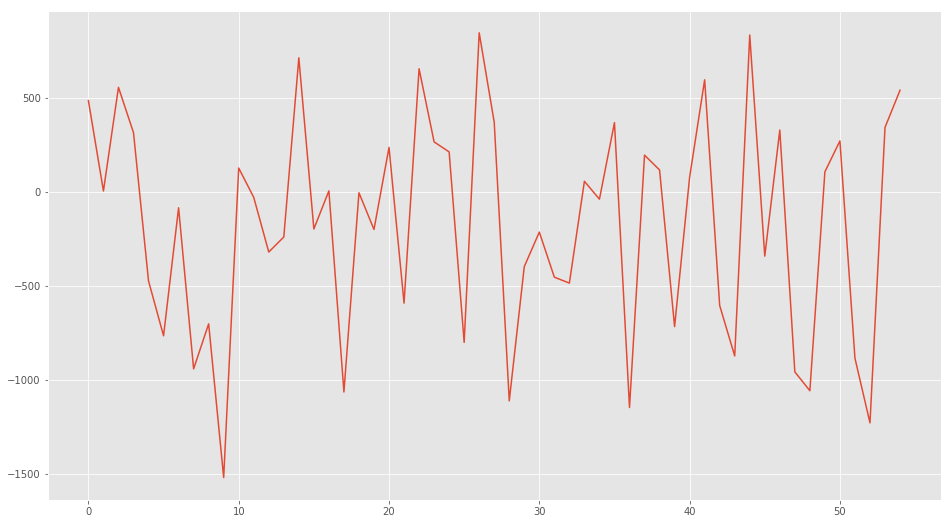

In [209]:
# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
plt.show()
#Make a plot to view basic situation of MVP Voting data

<h2>Fitting the neural network</h2>

After setting variables of our RNN model, we run the model and predict testing result and MVP in 17-18 seasom.

We set the number of epochs as 4000. Because we have test for many times and 4000 can be a relatively superior choice.

In [210]:
# Number of iterations or training cycles
epochs = 4000

In [211]:
#Run the model
#Display the changing process of mse every 500 epochs
with tf.Session() as sess:
    init.run()
    for e in range(epochs):
        sess.run(opt, feed_dict={X: X_train, Y: y_train})
        if e % 500 == 0:
            loss = mse.eval(feed_dict={X: X_train, Y: y_train})
            print(e, "\tMSE:", loss)
            
    y_pred = sess.run(out, feed_dict={X: X_test})
    # Predict MVP of new season
    MVP = sess.run(out, feed_dict={X: X_predict})

0 	MSE: 379564.0
500 	MSE: 0.00187836
1000 	MSE: 4.41761e-08
1500 	MSE: 2.67115e-09
2000 	MSE: 2.87407e-09
2500 	MSE: 94.346
3000 	MSE: 0.0872788
3500 	MSE: 3.32703e-05


**Copyright 2017 Sebastian Heinz**

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
    
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

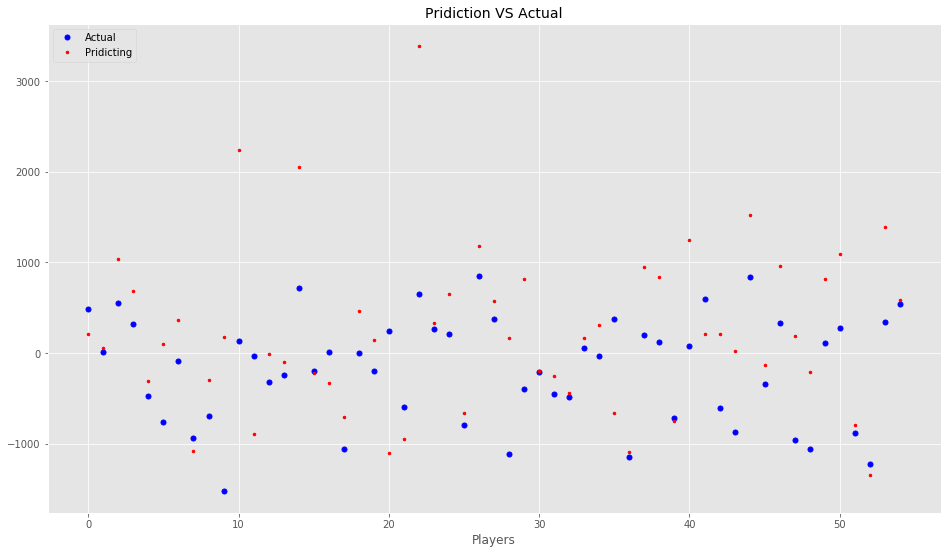

In [212]:
#First observe the accuracy of the predicting results and actual values of test data.
#Make the plot
plt.title("Pridiction VS Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize = 5, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize = 5, label="Pridicting")
plt.legend(loc="upper left")
plt.xlabel("Players")

plt.show()

<h2>Predicting MVP in 17-18 season</h2>

In [214]:
#Because the shape of MVP value array and Player array is different, transpose it.
MVP = MVP.T

In [217]:
#Combine the arrays and match the predicting results to the players.
Players = np.concatenate((data_result,MVP),axis=1)

In [218]:
#Sort players in desending order for MVP value
Players = Players[Players[:,51].argsort()][::-1]

In [219]:
Players

array([[248, 2018, 'LeBron James\\jamesle01', 'PF', 33, 'CLE', 82, 82,
        3026, 28.6, 0.621, 0.257, 0.336, 3.7, 22.3, 13.1, 44.4, 1.9, 2.0,
        16.1, 31.6, 11.0, 3.0, 14.0, 0.221, 7.6, 2.0, 9.6, 8.9, 857, 1580,
        0.542, 149, 406, 0.36700000000000005, 708, 1174, 0.603, 0.59, 388,
        531, 0.731, 97, 612, 709, 747, 116, 71, 347, 135, 2251,
        1887.946044921875],
       [194, 2018, 'James Harden\\hardeja01', 'SG', 28, 'HOU', 72, 72,
        2551, 29.8, 0.619, 0.498, 0.502, 1.8, 15.2, 8.6, 45.1, 2.4, 1.7,
        15.1, 36.1, 11.6, 3.8, 15.4, 0.289, 9.6, 1.3, 10.9, 8.3, 651, 1449,
        0.449, 265, 722, 0.36700000000000005, 386, 727, 0.531, 0.541, 624,
        727, 0.858, 41, 348, 389, 630, 126, 50, 315, 169, 2191,
        1769.217041015625],
       [298, 2018, 'Damian Lillard\\lillada01', 'PG', 27, 'POR', 73, 73,
        2670, 25.2, 0.594, 0.445, 0.38, 2.6, 10.6, 6.6, 30.9, 1.4, 0.8,
        11.1, 30.6, 9.9, 2.7, 12.6, 0.22699999999999998, 7.7, -1.0, 6.7,
        

<h2>Show specific players intuitively</h2>

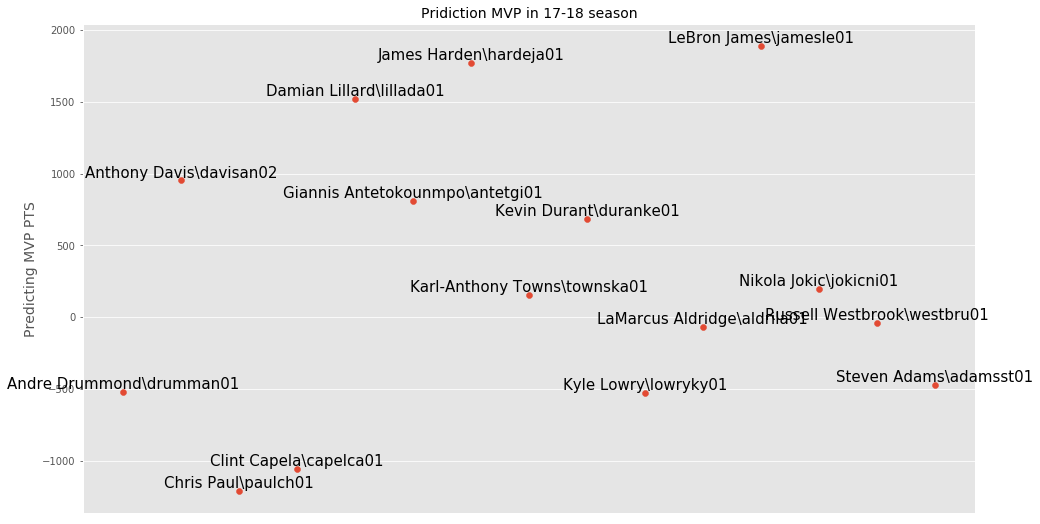

In [260]:
l = Players[:,2]
y = Players[:,51]

#Make the plot of predicting results of new season data
plt.title("Pridiction MVP in 17-18 season", fontsize=14)
plt.scatter(l, y, marker='o')  
plt.ylabel("Predicting MVP PTS", fontsize=14)
#Remove x label
plt.xticks([])
#Set labels
for a, b in zip(l, y):  
    plt.text(a, b, a, ha='center', va='bottom', fontsize=15)  
    
plt.show()

<h2>Conclusion</h2>

* Through the array above, LeBron James will win MVP of 17-18 NBA season in our model. It is quite different from the result in original model. James Harden and Kevin Durant are in second and third place respectively.

* After testing out model for many times, we could make the conclusion that the accuracy of our model has incresed by implementing PCA function. 